In [66]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [67]:
# Define the ticker symbol
tickerSymbol = 'MAGS'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
display(history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-04-10 00:00:00-04:00,24.643028,25.101039,24.145190,24.961645,96700,0.0,0.0,0.0
2023-04-17 00:00:00-04:00,24.901905,24.981559,24.623114,24.792379,26200,0.0,0.0,0.0
2023-04-24 00:00:00-04:00,24.956667,26.186328,24.185017,25.967279,36100,0.0,0.0,0.0
2023-05-01 00:00:00-04:00,25.827886,25.967280,25.400739,25.889618,43600,0.0,0.0,0.0
2023-05-08 00:00:00-04:00,25.770136,26.962958,25.770136,26.634384,32200,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-07-22 00:00:00-04:00,46.419998,47.189999,42.820000,43.889999,4430100,0.0,0.0,0.0
2024-07-29 00:00:00-04:00,44.230000,46.049999,42.130001,42.509998,4567800,0.0,0.0,0.0
2024-08-05 00:00:00-04:00,38.750000,42.490002,38.509998,42.439999,3726400,0.0,0.0,0.0


In [68]:
max_weeks = 52

In [69]:

gap = (1/45)*100

option_prices = {
    5: [45/1.62],
    8: [46/1.55],
    9: [45/2.05],
    17: [46/2.67],
    18: [45/3.35],
    30: [46/3.55],
    31: [45/4.05],
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 5w 27.8
	 8w 29.7
	 9w 22.0
	17w 17.2
	18w 13.4
	30w 13.0
	31w 11.1
mean option leverage, break even:
	 5w 27.8  5.8%
	 8w 29.7  5.6%
	 9w 22.0  6.8%
	17w 17.2  8.0%
	18w 13.4  9.7%
	30w 13.0  9.9%
	31w 11.1 11.2%
option gap: 2.22%


In [70]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [71]:
print('Option performance:\nweeks mean-profit median-profit positive w-max')
for p in option_performance:
    weeks = p[0]
    print(f'{weeks:4}w {p[1]:10.0f}% {p[4]:12.0f}% {p[2]:7.0f}% {p[3]:4.0f}%')

Option performance:
weeks mean-profit median-profit positive w-max
   5w         -3%          -63%      36%  -80%
   8w         73%           30%      56%   25%
   9w         41%            8%      52%  -18%
  17w        113%          142%      73%  104%
  18w         77%          108%      69%   60%
  30w        236%          227%     100%  173%
  31w        200%          199%      98%  137%


In [72]:
from file import save_file

save_file(tickerSymbol, option_performance)

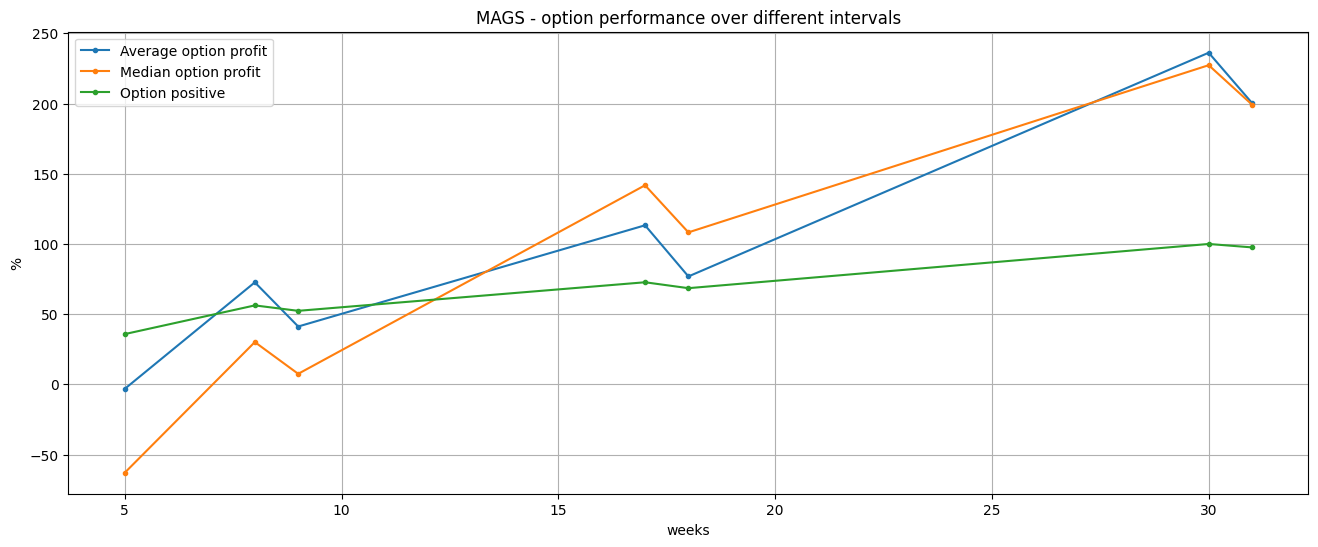

In [81]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_mean_profit = [p[1] for p in option_performance]
option_median_profit = [p[4] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_mean_profit, option_positive)]
plt.plot(option_weeks, option_mean_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_median_profit, label='Median option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
# plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

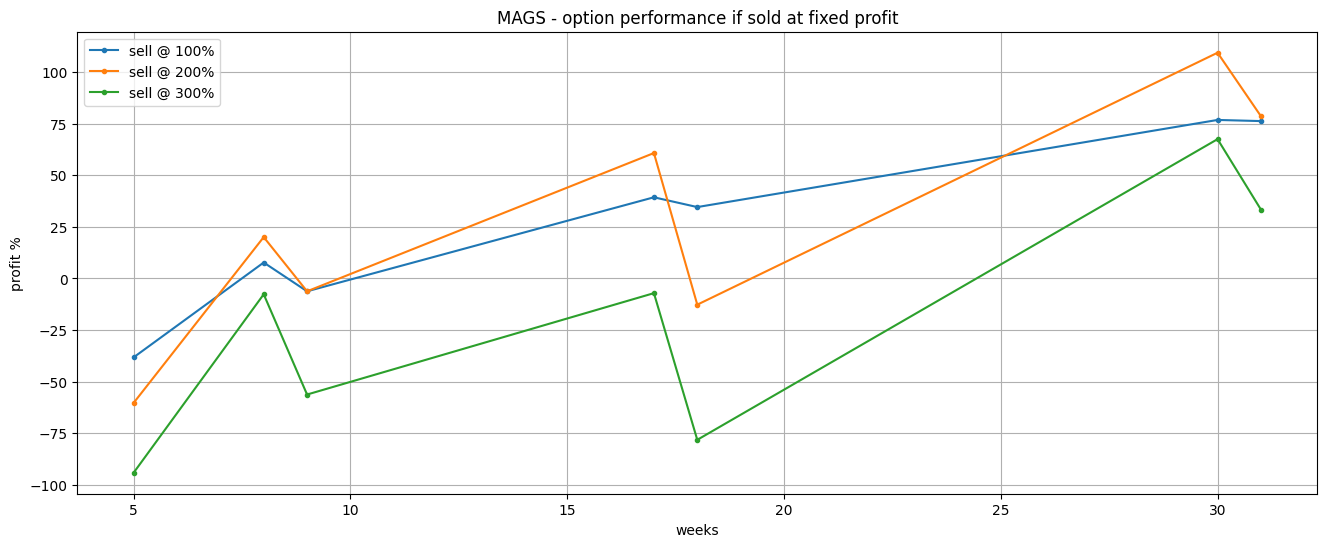

In [74]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        # print(f'{weeks}w q:{q:.2f} wmax:', wmax.describe())
        # display(wmax)
        data[weeks] = q * (percent + 100) - 100

    # display(data)
    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

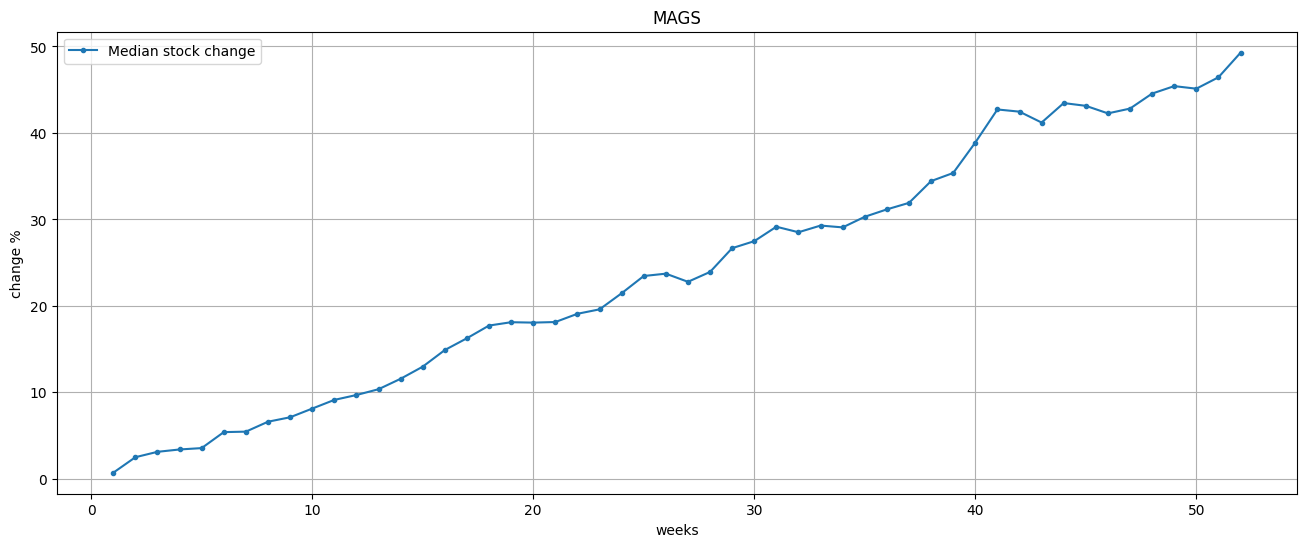

In [75]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


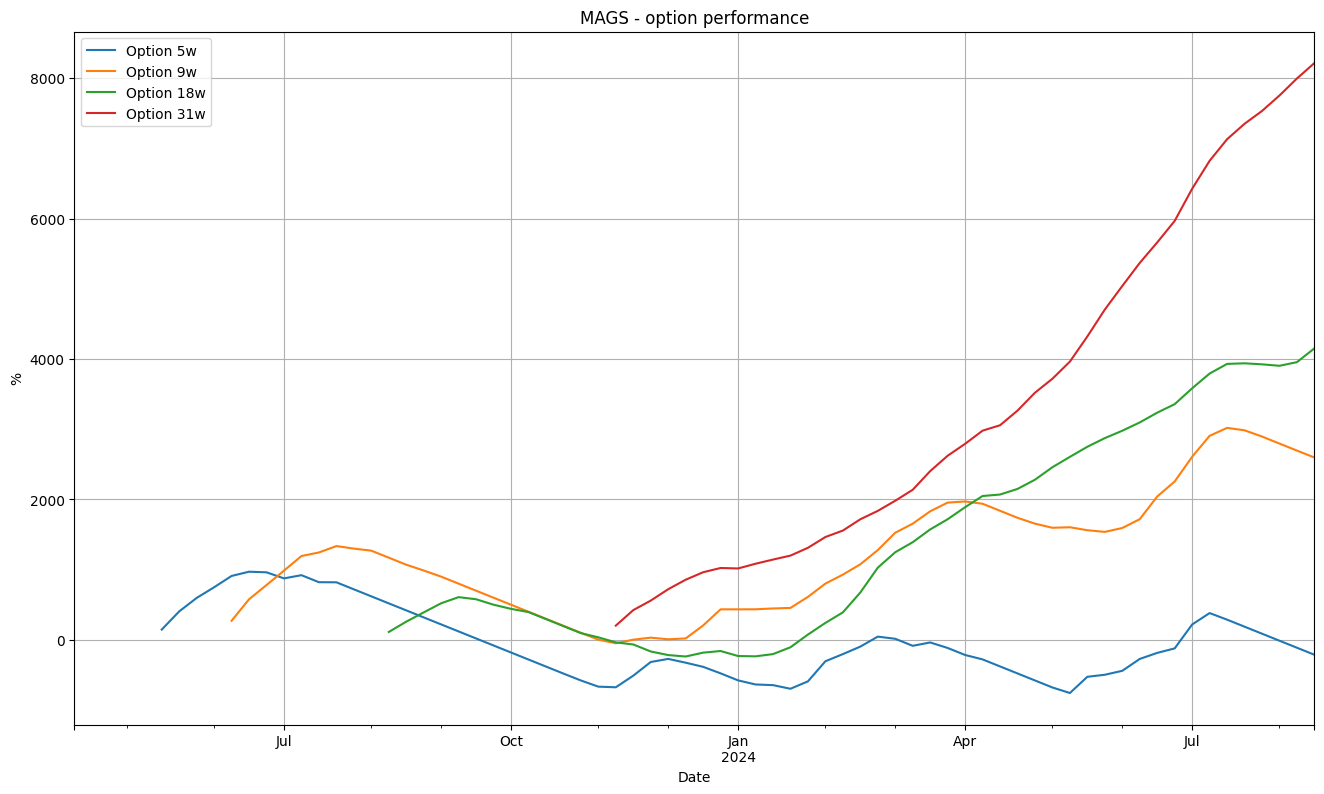

In [76]:
plt.figure(figsize=(16,9))

for w in [5,9,18,31]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


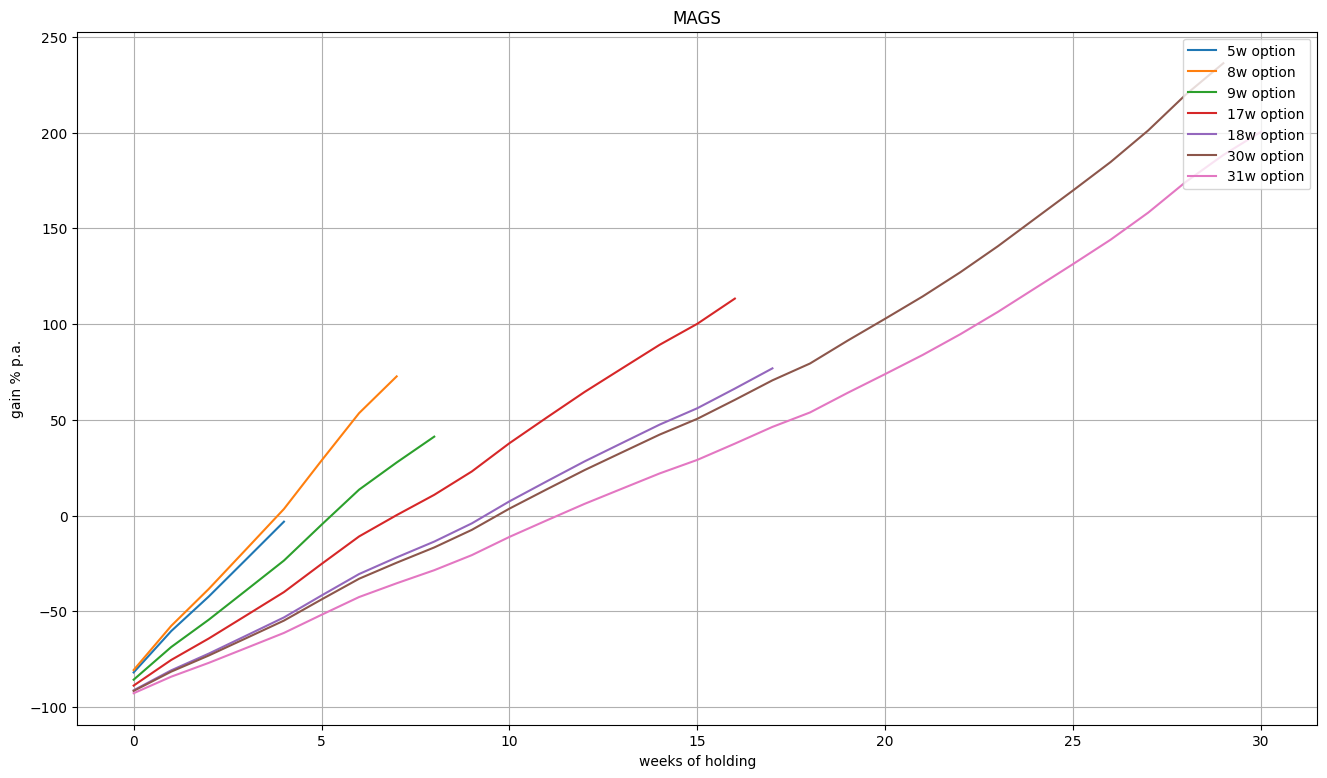

In [77]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = []
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain % p.a.')
plt.grid()
plt.show()